In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, DataCollatorWithPadding

from transformers import TrainingArguments, Trainer
from datasets import Dataset
from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients

/Users/stephentoner/miniconda3/envs/SI699proj/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps:0")

In [4]:
ds_train = Dataset.from_csv('train.csv')
ds_val = Dataset.from_csv('validate.csv')
ds_test = Dataset.from_csv('test.csv')
print(ds_test)
ds_test_viz = ds_test

ds = {"train": ds_train, "validation": ds_val, "test": ds_test, "test_viz": ds_test_viz}

Found cached dataset csv (/Users/stephentoner/.cache/huggingface/datasets/csv/default-eebe832ecc69a198/0.0.0)
Found cached dataset csv (/Users/stephentoner/.cache/huggingface/datasets/csv/default-a66aa153b2d656dd/0.0.0)
Found cached dataset csv (/Users/stephentoner/.cache/huggingface/datasets/csv/default-a295528222c270bc/0.0.0)


Dataset({
    features: ['user_id', 'tweet_id', 'tweet_text', 'country'],
    num_rows: 1000
})


In [5]:
id2label = {0: "United States", 1: "United Kingdom", 2: "Canada", 3: "Australia", 4: "India", 5: "Nigeria"}
label2id = {"United States": 0, "United Kingdom": 1, "Canada": 2, "Australia": 3, "India": 4, "Nigeria": 5}

In [6]:
model_path = 'twitter_baseline'

model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=6, id2label=id2label, label2id=label2id)
model = model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained('Twitter/twhin-bert-base')

def preprocess_function(examples):
    label = examples["country"] 
    examples = tokenizer(examples["tweet_text"], truncation=True, padding="max_length", max_length=256, return_tensors='pt')
    for key in examples:
        examples[key] = examples[key].squeeze(0)
    examples["label"] = label
    return examples

for split in ds:
    ds[split] = ds[split].map(preprocess_function, remove_columns=['user_id', 'tweet_id', 'tweet_text', 'country'])
    ds[split].set_format('pt')

Loading cached processed dataset at /Users/stephentoner/.cache/huggingface/datasets/csv/default-eebe832ecc69a198/0.0.0/cache-5008e1b070e860c9.arrow
Loading cached processed dataset at /Users/stephentoner/.cache/huggingface/datasets/csv/default-a66aa153b2d656dd/0.0.0/cache-8deeddce353a4144.arrow
Loading cached processed dataset at /Users/stephentoner/.cache/huggingface/datasets/csv/default-a295528222c270bc/0.0.0/cache-e735c56e2e51ad56.arrow
Loading cached processed dataset at /Users/stephentoner/.cache/huggingface/datasets/csv/default-a295528222c270bc/0.0.0/cache-e735c56e2e51ad56.arrow


In [7]:
ds['test_viz']

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 1000
})

In [8]:
import evaluate

accuracy = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": accuracy.compute(predictions=predictions, references=labels), "f1":f1_metric.compute(predictions=predictions, references=labels, average="weighted")}

In [9]:
import torch
class TwitterTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # print ("inputs: ", inputs)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = torch.nn.functional.cross_entropy(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [10]:
from transformers import TrainingArguments
from transformers import Trainer

training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = TwitterTrainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics
)


In [11]:
test_pred = trainer.predict(ds['test'])

100%|██████████| 63/63 [06:45<00:00,  6.44s/it]


In [13]:
top_predictions = np.argmax(test_pred.predictions,0)

In [14]:
highest_pred=np.argmax(test_pred.predictions,0)

plot_viz = {}

for idx, elt in enumerate(highest_pred):
    plot_viz[idx] = ds['test_viz'][int(elt)]

In [65]:
def forward_func(inputs, position = 0):
    """
        Wrapper around prediction method of pipeline
    """
    pred = model(inputs, attention_mask=torch.ones_like(inputs).to(device))
    return pred[position]
    
def visualize(inputs: list, attributes: list):
    """
        Visualization method.
        Takes list of inputs and correspondent attributs for them to visualize in a barplot
    """
    attr_sum = attributes.sum(-1) 
    
    attr = attr_sum / torch.norm(attr_sum)
    
    a = pd.Series(attr.numpy()[0][::-1], 
                        index = tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0][::-1]), name='Attribution')
    
    plt.figure(figsize=(10, 5))
    a.plot.barh()
    plt.xlabel('Attribution')
    plt.ylabel('Token')  # add a y-axis label if needed
    plt.show()
                    
def explain(text: str):
    """
        Main entry method. Passes text through series of transformations and through the model. 
        Calls visualization method.
    """
    prediction = trainer.predict(text)
    inputs = generate_inputs(text)
    baseline = generate_baseline(sequence_len = inputs.shape[1])
    
    lig = LayerIntegratedGradients(forward_func, getattr(model, 'Twitter/twhin-bert-base').embeddings)
    
    attributes, delta = lig.attribute(inputs=inputs,
                                baselines=baseline,
                                target = model.config.label2id[prediction[0]['label']], 
                                return_convergence_delta = True)
    
    visualize(inputs, attributes, prediction)
    
def generate_inputs(text: str):
    """
        Convenience method for generation of input ids as list of torch tensors
    """
    return tokenizer.encode(text, truncation=True, max_length=256, return_tensors='pt').to(device)

def generate_baseline(sequence_len: int):
    """
        Convenience method for generation of baseline vector as list of torch tensors
    """        
    return torch.tensor([tokenizer.cls_token_id] + [tokenizer.pad_token_id] * (sequence_len - 2) + [tokenizer.sep_token_id], device = device).unsqueeze(0)




In [ ]:
factory = iter(ds['test_viz'])
text = iter(ds_test_viz)

USA

In [66]:
example = plot_viz[0]
example_text = ds_test_viz[int(highest_pred[0])]['tweet_text']
example_text

print(example_text)


prediction = trainer.predict([example])
# prediction = trainer.predict([example])

label = model.config.id2label[prediction.label_ids[0]]
print(label)

inputs = generate_inputs(example_text)
# inputs = example['input_ids']
baseline = generate_baseline(sequence_len = inputs.shape[1])
lig = LayerIntegratedGradients(forward_func, model.bert.embeddings)
attributes, delta = lig.attribute(inputs=inputs,
                            baselines=baseline,
                            target = model.config.label2id[model.config.id2label[prediction.label_ids[0]]], 
                            return_convergence_delta = True)
visualize(inputs, attributes)

# Second from test set

@NCAABaseball @TCU_Baseball Ejection for “excessive” celebration!


100%|██████████| 1/1 [00:00<00:00, 57.71it/s]


United States


In [50]:
attr = attributes.sum(dim=2).squeeze(0)
attr = attr / torch.norm(attr)
attr = attr.cpu().detach().numpy()
softmax = nn.Softmax()

softmax(torch.Tensor(prediction.predictions))
class_ =  np.argmax(softmax(torch.Tensor(prediction.predictions)).numpy()[0]) # True Class

rec = viz.VisualizationDataRecord(attr, 
                            np.max(softmax(torch.Tensor(prediction.predictions)).numpy()[0]),
                            
                            id2label[class_],
                            id2label[model.config.label2id[model.config.id2label[prediction.label_ids[0]]]], # Predicted Label
                            id2label[class_], # Attribute class
                            attributes.sum(), # attribute score
                            tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0]), # Raw inputs
                            delta)
viz.visualize_text([rec])

/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_52191/2267478616.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(torch.Tensor(prediction.predictions))
/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_52191/2267478616.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  class_ =  np.argmax(softmax(torch.Tensor(prediction.predictions)).numpy()[0]) # True Class
/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_52191/2267478616.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  np.max(softmax(torch.Tensor(prediction.predictions)).numpy()[0]),


UK

@TalkTV @JuliaHB1 Great news. Common sense prevails.


100%|██████████| 1/1 [00:00<00:00, 142.01it/s]


United Kingdom


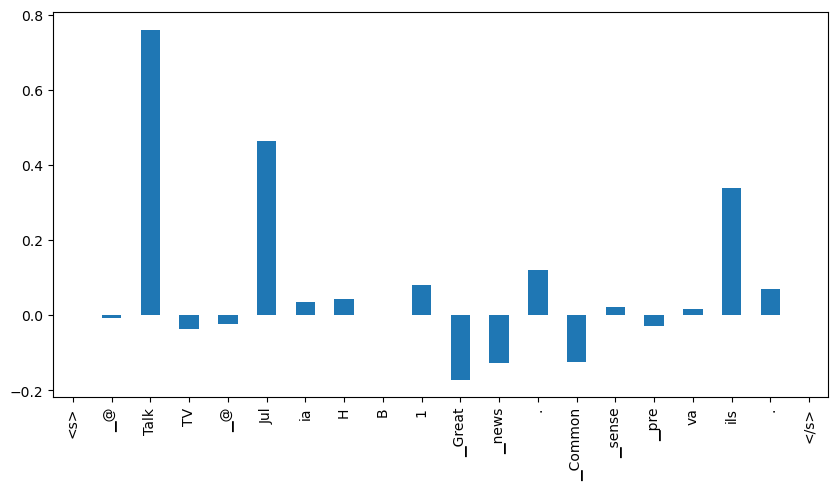

In [27]:
example = plot_viz[1]
example_text = ds_test_viz[int(highest_pred[1])]['tweet_text']
example_text

print(example_text)


prediction = trainer.predict([example])
# prediction = trainer.predict([example])

label = model.config.id2label[prediction.label_ids[0]]
print(label)

inputs = generate_inputs(example_text)
# inputs = example['input_ids']
baseline = generate_baseline(sequence_len = inputs.shape[1])
lig = LayerIntegratedGradients(forward_func, model.bert.embeddings)
attributes, delta = lig.attribute(inputs=inputs,
                            baselines=baseline,
                            target = model.config.label2id[model.config.id2label[prediction.label_ids[0]]], 
                            return_convergence_delta = True)
visualize(inputs, attributes)

# Second from test set

In [28]:
attr = attributes.sum(dim=2).squeeze(0)
attr = attr / torch.norm(attr)
attr = attr.cpu().detach().numpy()
softmax = nn.Softmax()

softmax(torch.Tensor(prediction.predictions))
class_ =  np.argmax(softmax(torch.Tensor(prediction.predictions)).numpy()[0]) # True Class

rec = viz.VisualizationDataRecord(attr, 
                            np.max(softmax(torch.Tensor(prediction.predictions)).numpy()[0]),
                            
                            id2label[class_],
                            id2label[model.config.label2id[model.config.id2label[prediction.label_ids[0]]]], # Predicted Label
                            id2label[class_], # Attribute class
                            attributes.sum(), # attribute score
                            tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0]), # Raw inputs
                            delta)
viz.visualize_text([rec])

/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_52191/2267478616.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(torch.Tensor(prediction.predictions))
/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_52191/2267478616.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  class_ =  np.argmax(softmax(torch.Tensor(prediction.predictions)).numpy()[0]) # True Class
/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_52191/2267478616.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  np.max(softmax(torch.Tensor(prediction.predictions)).numpy()[0]),


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
United Kingdom,United Kingdom (0.89),United Kingdom,3.23,#s ▁@ Talk TV ▁@ Jul ia H B 1 ▁Great ▁news . ▁Common ▁sense ▁pre va ils . #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
United Kingdom,United Kingdom (0.89),United Kingdom,3.23,#s ▁@ Talk TV ▁@ Jul ia H B 1 ▁Great ▁news . ▁Common ▁sense ▁pre va ils . #/s


Canada

@BSReviewsUK @Walmart I’d post pics, but I can’t get any in 🇨🇦 🤬


100%|██████████| 1/1 [00:00<00:00, 115.23it/s]


Canada


/Users/stephentoner/miniconda3/envs/SI699proj/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127464 (\N{REGIONAL INDICATOR SYMBOL LETTER C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/stephentoner/miniconda3/envs/SI699proj/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127462 (\N{REGIONAL INDICATOR SYMBOL LETTER A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


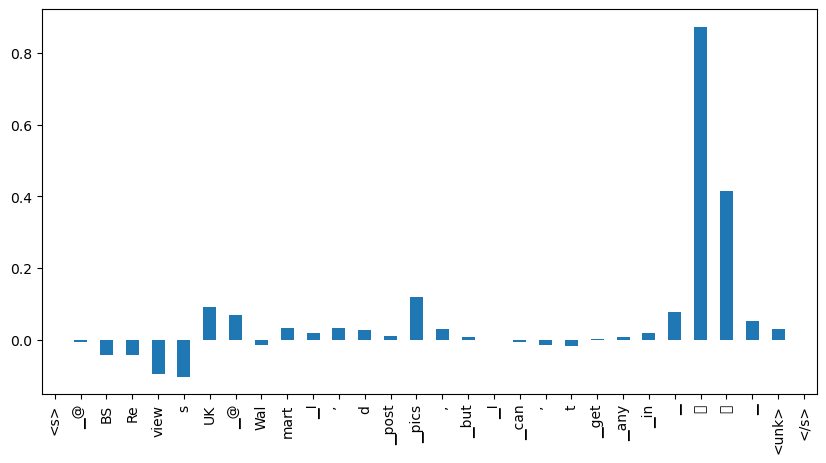

In [30]:
example = plot_viz[2]
example_text = ds_test_viz[int(highest_pred[2])]['tweet_text']
example_text

print(example_text)


prediction = trainer.predict([example])
# prediction = trainer.predict([example])

label = model.config.id2label[prediction.label_ids[0]]
print(label)

inputs = generate_inputs(example_text)
# inputs = example['input_ids']
baseline = generate_baseline(sequence_len = inputs.shape[1])
lig = LayerIntegratedGradients(forward_func, model.bert.embeddings)
attributes, delta = lig.attribute(inputs=inputs,
                            baselines=baseline,
                            target = model.config.label2id[model.config.id2label[prediction.label_ids[0]]], 
                            return_convergence_delta = True)
visualize(inputs, attributes)

# Second from test set

In [31]:
attr = attributes.sum(dim=2).squeeze(0)
attr = attr / torch.norm(attr)
attr = attr.cpu().detach().numpy()
softmax = nn.Softmax()

softmax(torch.Tensor(prediction.predictions))
class_ =  np.argmax(softmax(torch.Tensor(prediction.predictions)).numpy()[0]) # True Class

rec = viz.VisualizationDataRecord(attr, 
                            np.max(softmax(torch.Tensor(prediction.predictions)).numpy()[0]),
                            
                            id2label[class_],
                            id2label[model.config.label2id[model.config.id2label[prediction.label_ids[0]]]], # Predicted Label
                            id2label[class_], # Attribute class
                            attributes.sum(), # attribute score
                            tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0]), # Raw inputs
                            delta)
viz.visualize_text([rec])

/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_52191/2267478616.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(torch.Tensor(prediction.predictions))
/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_52191/2267478616.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  class_ =  np.argmax(softmax(torch.Tensor(prediction.predictions)).numpy()[0]) # True Class
/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_52191/2267478616.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  np.max(softmax(torch.Tensor(prediction.predictions)).numpy()[0]),


AU

It’s time to #actfortheyarra! @rwynnemp @EJ_Aus @TheYarraRiver https://t.co/hQvGJ2e2UC


100%|██████████| 1/1 [00:00<00:00, 121.58it/s]


Australia


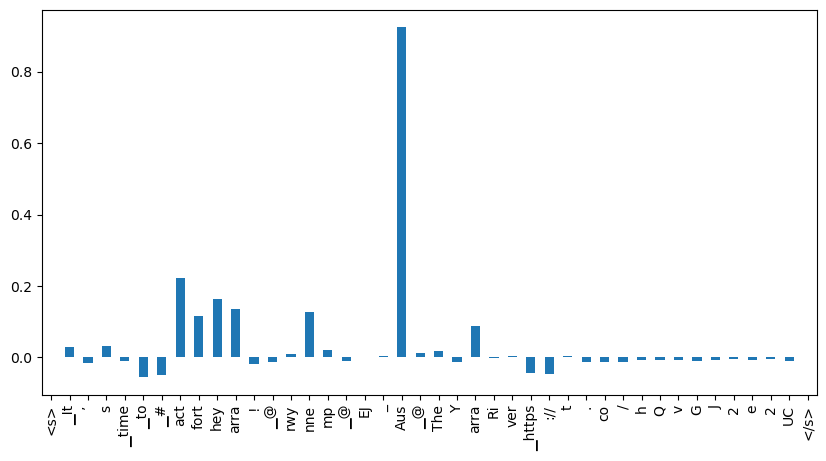

In [32]:
example = plot_viz[3]
example_text = ds_test_viz[int(highest_pred[3])]['tweet_text']
example_text

print(example_text)


prediction = trainer.predict([example])
# prediction = trainer.predict([example])

label = model.config.id2label[prediction.label_ids[0]]
print(label)

inputs = generate_inputs(example_text)
# inputs = example['input_ids']
baseline = generate_baseline(sequence_len = inputs.shape[1])
lig = LayerIntegratedGradients(forward_func, model.bert.embeddings)
attributes, delta = lig.attribute(inputs=inputs,
                            baselines=baseline,
                            target = model.config.label2id[model.config.id2label[prediction.label_ids[0]]], 
                            return_convergence_delta = True)
visualize(inputs, attributes)


In [33]:
attr = attributes.sum(dim=2).squeeze(0)
attr = attr / torch.norm(attr)
attr = attr.cpu().detach().numpy()
softmax = nn.Softmax()

softmax(torch.Tensor(prediction.predictions))
class_ =  np.argmax(softmax(torch.Tensor(prediction.predictions)).numpy()[0]) # True Class

rec = viz.VisualizationDataRecord(attr, 
                            np.max(softmax(torch.Tensor(prediction.predictions)).numpy()[0]),
                            
                            id2label[class_],
                            id2label[model.config.label2id[model.config.id2label[prediction.label_ids[0]]]], # Predicted Label
                            id2label[class_], # Attribute class
                            attributes.sum(), # attribute score
                            tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0]), # Raw inputs
                            delta)
viz.visualize_text([rec])

/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_52191/2267478616.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(torch.Tensor(prediction.predictions))
/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_52191/2267478616.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  class_ =  np.argmax(softmax(torch.Tensor(prediction.predictions)).numpy()[0]) # True Class
/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_52191/2267478616.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  np.max(softmax(torch.Tensor(prediction.predictions)).numpy()[0]),


India

@Swamy39 @ArtiSharma001 @jagdishshetty Call  or text him and ask.


100%|██████████| 1/1 [00:00<00:00, 31.88it/s]


India


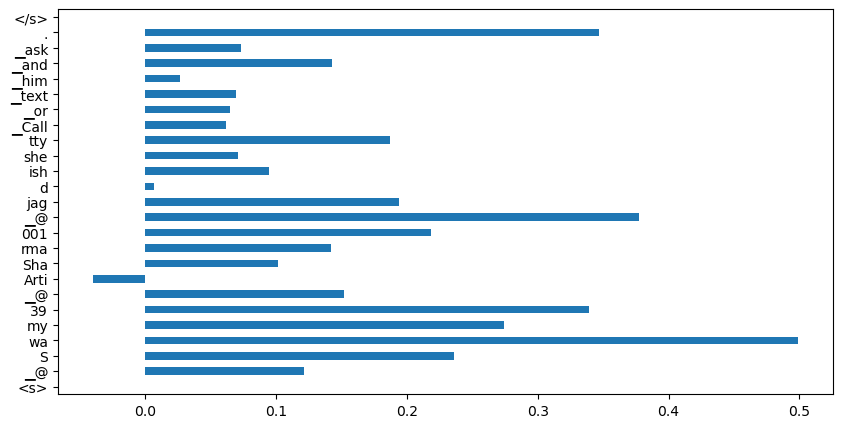

In [46]:
example = plot_viz[4]
example_text = ds_test_viz[int(highest_pred[4])]['tweet_text']
example_text

print(example_text)


prediction = trainer.predict([example])
# prediction = trainer.predict([example])

label = model.config.id2label[prediction.label_ids[0]]
print(label)

inputs = generate_inputs(example_text)
# inputs = example['input_ids']
baseline = generate_baseline(sequence_len = inputs.shape[1])
lig = LayerIntegratedGradients(forward_func, model.bert.embeddings)
attributes, delta = lig.attribute(inputs=inputs,
                            baselines=baseline,
                            target = model.config.label2id[model.config.id2label[prediction.label_ids[0]]], 
                            return_convergence_delta = True)
visualize(inputs, attributes)


In [47]:
attr = attributes.sum(dim=2).squeeze(0)
attr = attr / torch.norm(attr)
attr = attr.cpu().detach().numpy()
softmax = nn.Softmax()

softmax(torch.Tensor(prediction.predictions))
class_ =  np.argmax(softmax(torch.Tensor(prediction.predictions)).numpy()[0]) # True Class

rec = viz.VisualizationDataRecord(attr, 
                            np.max(softmax(torch.Tensor(prediction.predictions)).numpy()[0]),
                            
                            id2label[class_],
                            id2label[model.config.label2id[model.config.id2label[prediction.label_ids[0]]]], # Predicted Label
                            id2label[class_], # Attribute class
                            attributes.sum(), # attribute score
                            tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0]), # Raw inputs
                            delta)
viz.visualize_text([rec])

/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_52191/2267478616.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(torch.Tensor(prediction.predictions))
/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_52191/2267478616.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  class_ =  np.argmax(softmax(torch.Tensor(prediction.predictions)).numpy()[0]) # True Class
/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_52191/2267478616.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  np.max(softmax(torch.Tensor(prediction.predictions)).numpy()[0]),


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
India,India (0.95),India,3.20,#s ▁@ S wa my 39 ▁@ Arti Sha rma 001 ▁@ jag d ish she tty ▁Call ▁or ▁text ▁him ▁and ▁ask . #/s


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
India,India (0.95),India,3.20,#s ▁@ S wa my 39 ▁@ Arti Sha rma 001 ▁@ jag d ish she tty ▁Call ▁or ▁text ▁him ▁and ▁ask . #/s


Nigeria

Polling unit is not ward olodo media man https://t.co/QxD4WaWNbL


100%|██████████| 1/1 [00:00<00:00, 60.39it/s]


Nigeria


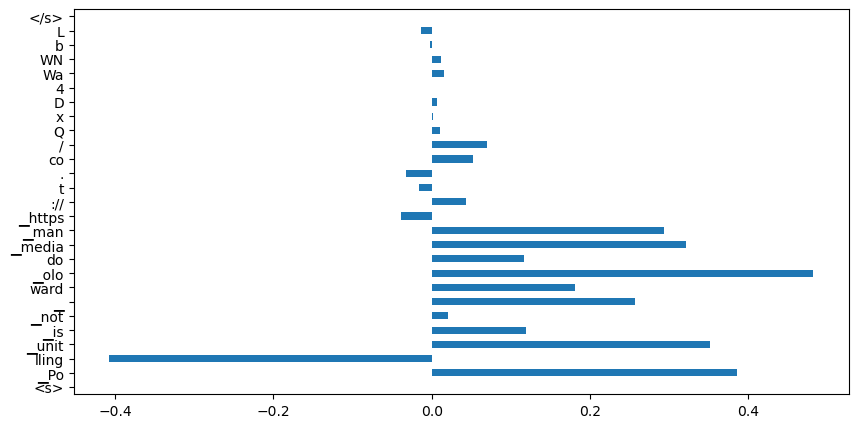

In [43]:
example = plot_viz[5]
example_text = ds_test_viz[int(highest_pred[5])]['tweet_text']
example_text

print(example_text)


prediction = trainer.predict([example])
# prediction = trainer.predict([example])

label = model.config.id2label[prediction.label_ids[0]]
print(label)

inputs = generate_inputs(example_text)
# inputs = example['input_ids']
baseline = generate_baseline(sequence_len = inputs.shape[1])
lig = LayerIntegratedGradients(forward_func, model.bert.embeddings)
attributes, delta = lig.attribute(inputs=inputs,
                            baselines=baseline,
                            target = model.config.label2id[model.config.id2label[prediction.label_ids[0]]], 
                            return_convergence_delta = True)
visualize(inputs, attributes)


In [37]:
attr = attributes.sum(dim=2).squeeze(0)
attr = attr / torch.norm(attr)
attr = attr.cpu().detach().numpy()
softmax = nn.Softmax()

softmax(torch.Tensor(prediction.predictions))
class_ =  np.argmax(softmax(torch.Tensor(prediction.predictions)).numpy()[0]) # True Class

rec = viz.VisualizationDataRecord(attr, 
                            np.max(softmax(torch.Tensor(prediction.predictions)).numpy()[0]),
                            
                            id2label[class_],
                            id2label[model.config.label2id[model.config.id2label[prediction.label_ids[0]]]], # Predicted Label
                            id2label[class_], # Attribute class
                            attributes.sum(), # attribute score
                            tokenizer.convert_ids_to_tokens(inputs.detach().numpy()[0]), # Raw inputs
                            delta)
viz.visualize_text([rec])

/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_52191/2267478616.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(torch.Tensor(prediction.predictions))
/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_52191/2267478616.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  class_ =  np.argmax(softmax(torch.Tensor(prediction.predictions)).numpy()[0]) # True Class
/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_52191/2267478616.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  np.max(softmax(torch.Tensor(prediction.predictions)).numpy()[0]),
